In [98]:
# Imports

#import gymnasium as gym
import importlib
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque, defaultdict
from itertools import count
import numpy as np
import sys
import time
import copy
import pickle
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [99]:
# Parameters

COLUMN_LEN = 3

# Reduced grid size
# All cards are visible
# The player can only draws from the pile

In [100]:
# Import environment

from environments import define_custom_pile
from environments import ColumnSkyjo


In [101]:
# Plots and render functions

# Print the board
def print_board(state, unhide=False):
    deck_values = state["deck_values"]
    deck_mask = state["deck_mask"]
    drawn_card = state["drawn_card"]
    round_id = state["round_id"]
    done = state["done"]

    print("-" * 50)
    print("")
    print(f"Round {round_id}")
    print("")

    if done:
        print("The game has ended!")
        print(f"Final score: {np.sum(deck_values)}")
        unhide=True
    if unhide:
        print(f"-> {drawn_card}")
        print("-" * 6 + "    " + "-"*6)
        for i in range(len(deck_values)):
            if deck_mask[i] == 1:
                print(f"| {deck_values[i]:02} |" + "    " + f"| {deck_values[i]:02} |")
            else:
                print("| ** |" + "    " + f"| {deck_values[i]:02} |" )
        print("-" * 6 + "    " + "-"*6)
    else:
        print(f"-> {drawn_card}")
        print("-" * 6)
        for i in range(len(deck_values)):
            if deck_mask[i] == 1:
                print(f"| {deck_values[i]:02} |")
            else:
                print("| ** |")
        print("-" * 6)
    print("")
    print("-" * 50)

# Plot the scores histogram
def plot_hist_scores(scores):
    n_games = len(scores)
    mean = np.mean(scores)
    std = np.std(scores)
    
    plt.figure(figsize=(8, 6))
    plt.hist(scores, bins=np.arange(-6.5, 37.5, 1), range=(-6, 36), edgecolor='black')

    plt.title(f"Scores histogram (Mean: {mean:.2f}, Std: {std:.2f})")
    plt.xlabel("Final sum")
    plt.ylabel("Frequency")

    plt.xlim(-6.5,36.5)
    plt.ylim(0, 0.35*n_games)

    plt.show()

In [102]:
# Encode observation

def encode_obs(obs, argsort=False):
    return tuple(map(int,obs))

def encode_obs_int(obs, argsort=False):
    [x1, x2, x3, drawn_card] = obs 
    x1 += 3         # [0,16[
    x2 += 3         # [0,16[
    x3 += 3         # [0,16[
    drawn_card += 2 # [0,15[
    return drawn_card + 15*(x1 + 16 * (x2 + 16 * x3))

def decode_obs_int(id):
    drawn_card = id % 15
    res = (id - drawn_card) // 15
    x1 = res % 16
    res = (res - x1) // 16
    x2 = res % 16
    res = (res - x2) // 16
    x3 = res % 16

    drawn_card += -2
    x3 += -3
    x2 += -3
    x1 += -3
    
    return np.array([x1,x2,x3,drawn_card])

In [103]:
# Observation space

def get_all_observations_encoded():
    states = []
    trivial_states = []
    for i in range(-3,13):
        for j in range(i,13):
            for k in range(j,13):
                is_sum_nonnegative = (i + j + k) > 0
                is_there_hidden_card = (i == -3 or j == -3 or k == -3)
                is_same_card = (i == j) and (j == k)
                for l in range(-2,13):
                    if is_there_hidden_card or (is_sum_nonnegative and not is_same_card):
                        states.append((i,j,k,l))
                    else:
                        trivial_states.append((i,j,k,l))

    return states, trivial_states

ALL_OBSERVATIONS_ENCODED, TRIVIAL_OBSERVATIONS_ENCODED = get_all_observations_encoded()
# Size of the observation space:
print(f"Size of the observation space: {len(ALL_OBSERVATIONS_ENCODED)}+{len(TRIVIAL_OBSERVATIONS_ENCODED)}={len(ALL_OBSERVATIONS_ENCODED) + len(TRIVIAL_OBSERVATIONS_ENCODED)}")

Size of the observation space: 11715+525=12240


In [104]:
# Evaluation functions

def play_game(env, Q):
    obs = env.reset()
    done = False
    while not done:
        encoded_obs = encode_obs(obs)
        action = Q[encoded_obs].argmax()
        obs, reward, done = env.step(action)
    final_score = env.get_sum_cards()
    return final_score

def evaluate(env, Q, num_episodes=1000):
    scores = np.zeros(num_episodes)
    for i in range(num_episodes):
        scores[i] = play_game(env, Q)
    return scores

In [105]:
# Monte-Carlo agent

class MCAgent:
    def __init__(self, number_actions):
        self.number_actions = number_actions
        self.policy = None
        self.Q = defaultdict(lambda: np.zeros(number_actions))
        self.states_visits = defaultdict(lambda: 0)
        self.state_action_visits = defaultdict(lambda: np.zeros(number_actions))
    
    def select_action(self, obs, eps=0):
        Q_obs = self.Q[encode_obs(obs)]
        if np.random.rand() < eps:
            action = np.random.choice(np.arange(len(Q_obs)))
        else:
            action = np.argmax(Q_obs)

        return action

    def generate_episode_from_Q(self, env, Q, epsilon):
        """ generates an episode from following the epsilon-greedy policy """
        episode = []
        obs = env.reset()
        sum_reward = 0
        while True:
            encoded_obs = encode_obs(obs, argsort=True)
            action = self.select_action(obs, eps=epsilon)
            next_obs, reward, done = env.step(action)
            sum_reward += reward
            episode.append((encoded_obs, action, reward))
            obs = next_obs
            if done:
                break
        return episode, sum_reward
    
    def update_Q(self, episode, gamma):
        """ updates the action-value function estimate using the most recent episode """
        observations, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, obs in enumerate(observations):
            self.states_visits[obs] += 1
            self.state_action_visits[obs][actions[i]] += 1
            G = sum(rewards[i:] * discounts[:len(rewards)-i])
            old_Q = self.Q[obs][actions[i]]
            step_size = 1 / self.state_action_visits[obs][actions[i]] # Counts the number of visits
            self.Q[obs][actions[i]] = old_Q + step_size * (G - old_Q)

    def train_agent(self, env, num_episodes, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
        total_rewards = []
        epsilon = eps_start

        for i_episode in range(1, num_episodes+1):
            if i_episode % 1000 == 0:
                eta = int(53*60 * (env.max_rounds / 10) * ((num_episodes + 1 - i_episode) / 20e6))
                mins = eta // 60
                secs = eta % 60
                print(f"\rEpisode {i_episode}/{num_episodes} (eps={epsilon:.02f}). Estimated remaining time: {mins:02}:{secs:02}", end="")
                sys.stdout.flush()

            epsilon = max(epsilon*eps_decay, eps_min)

            episode, sum_reward = self.generate_episode_from_Q(env, self.Q, epsilon)
            total_rewards.append(sum_reward)

            self.update_Q(episode, gamma)

        # For trivial states, where the sum of the cards is below 0, we assign -inf
        for key in TRIVIAL_OBSERVATIONS_ENCODED:
            self.Q[key] = np.full((self.number_actions), -np.inf)
        
        return np.array(total_rewards)

In [106]:
# Prepare agent training

env = ColumnSkyjo(grid_len=3, max_rounds=10, initial_visible_cards=0)

num_episodes = 100000
gamma = 1.
eps_start = 1.
eps_min = 1.
eps_decay = np.power(eps_min/eps_start, 1/(1 * num_episodes))

agent_mc = MCAgent(number_actions=4)

In [107]:
# First step: train with epsilon = 1

total_rewards = agent_mc.train_agent(env, num_episodes, gamma=gamma, eps_min=eps_start)
percentage_explored_states = len(agent_mc.Q) / (len(ALL_OBSERVATIONS_ENCODED) + len(TRIVIAL_OBSERVATIONS_ENCODED))
print(f"\nExplored states: {len(agent_mc.Q) }/{len(ALL_OBSERVATIONS_ENCODED) + len(TRIVIAL_OBSERVATIONS_ENCODED)} ({100*percentage_explored_states:.01f} %)")

Episode 100000/100000 (eps=1.00). Estimated remaining time: 00:00
Explored states: 12238/12240 (100.0 %)


In [ ]:
# Second step: decays epsilon

total_rewards = agent_mc.train_agent(env, num_episodes, gamma=gamma, eps_decay=eps_decay, eps_min=eps_min)

Episode 18000/100000 (eps=1.00). Estimated remaining time: 00:13

In [ ]:
# Third step: training with epsilon = 0.05

total_rewards = agent_mc.train_agent(env, num_episodes, gamma=gamma, eps_start=eps_min, eps_decay=eps_decay, eps_min=eps_min)

Episode 10000000/10000000 (eps=0.05). Estimated remaining time: 00:00

In [ ]:
# Unexplored states

for key in ALL_OBSERVATIONS_ENCODED:
    if key not in agent_mc.Q:
        print(key)

In [ ]:
# Underexplored states

threshold = 500
keys_under_explored = [k for k, v in agent_mc.states_visits.items() if v < threshold]
print(f"There are {len(keys_under_explored)} states that were visisted less than {threshold} times.")
print(keys_under_explored)

There are 38 states that were visisted less than 1000 times.
[(-2, -2, 12, 7), (-2, -2, 12, -1), (-2, -2, 6, -2), (-2, -2, 11, 7), (-2, -2, 11, 9), (-2, -2, 12, 1), (-2, -2, 11, 11), (-2, -2, 11, 2), (-2, 12, 12, -2), (-2, -2, 12, 10), (-2, -2, 12, 2), (-2, -2, 12, 5), (-2, -2, 11, 3), (-2, -2, 11, 8), (-2, -2, 12, 8), (-2, -2, 8, -2), (-2, -2, 11, 1), (-2, -2, 12, 12), (-2, -2, 12, 11), (-2, -2, 11, 6), (-2, -2, 10, -2), (-2, -2, 7, -2), (-2, 9, 9, -2), (-2, 11, 11, -2), (-2, -2, 12, 9), (-2, -2, 11, 5), (-2, -2, 11, -2), (-2, -2, 11, -1), (-2, -2, 11, 12), (-2, -2, 12, 4), (-2, 10, 10, -2), (-2, -2, 11, 10), (-2, -2, 12, -2), (-2, -2, 5, -2), (-2, -2, 10, 10), (-2, -2, 12, 6), (-2, -2, 11, 4), (-2, -2, 9, -2)]


In [ ]:
# Save and load learned Q-values

# Save learned Q-values
#joblib.dump(dict(agent_mc.Q), "q_values_column_max10rounds.joblib")

# Load saved Q-values
#Q = joblib.load("q_values_column_max10rounds.joblib")
Q = joblib.load("q_values_column_max5rounds.joblib")
print(f"Q-values dict loaded: {len(Q)} entries")

#Q = agent_mc.Q

Q-values dict loaded: 12240 entries


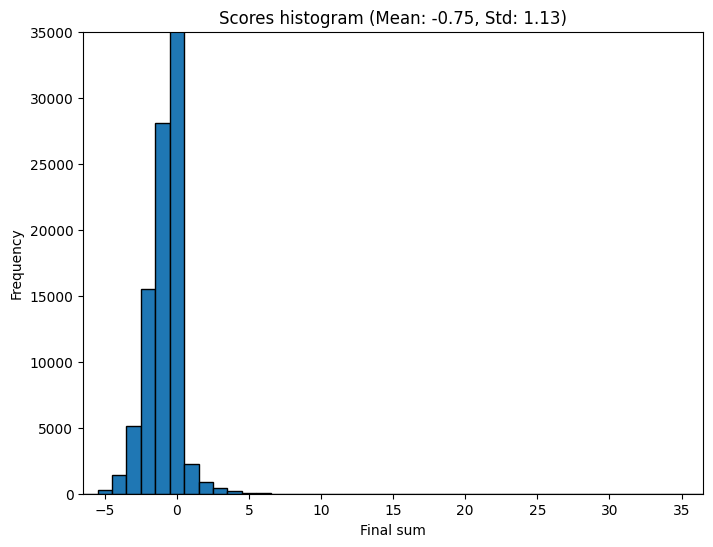

In [ ]:
# Plot the histogram

env = ColumnSkyjo(grid_len=3, max_rounds=20)
scores = evaluate(env, Q, num_episodes=100000)
plot_hist_scores(scores)

In [ ]:
# Test the agent

x = 12
first_cards = [x,x-1,x,0,x]
custom_pile = define_custom_pile(first_cards)

env = ColumnSkyjo(grid_len=3, max_rounds=10)
obs = env.reset(custom_pile=custom_pile, initial_visible_cards=3)
#obs = env.reset(initial_visible_cards=3)
#obs = env.reset()

done = False
while not done:
    print_board(env.get_state(), unhide=False)
    encoded_obs = encode_obs(obs)
    print("q-value", Q[encoded_obs])
    action = Q[encoded_obs].argmax()
    if action == 0:
        print(f"The player discards the card")
    else:
        print(f"The player use the card and replace the {action}-th lowest card")
    next_obs, reward, done = env.step(action)
    time.sleep(2)
    obs = next_obs

print_board(env.get_state(), unhide=False)

Custom pile:  [12 11 12  0 12 12  4  3  7  0]
--------------------------------------------------

Round 0

-> 0
------
| 12 |
| 11 |
| 12 |
------

--------------------------------------------------
q-value [-33.16299559 -23.08583691 -21.66666667 -22.4       ]
The player use the card and replace the 2-th lowest card
--------------------------------------------------

Round 1

-> 12
------
| 00 |
| 11 |
| 12 |
------

--------------------------------------------------
q-value [-21.25102319 -32.98249453 -22.73493976 -22.27108434]
The player discards the card
--------------------------------------------------

Round 2

-> 12
------
| 00 |
| 11 |
| 12 |
------

--------------------------------------------------
q-value [-21.25102319 -32.98249453 -22.73493976 -22.27108434]
The player discards the card
--------------------------------------------------

Round 3

-> 4
------
| 00 |
| 11 |
| 12 |
------

--------------------------------------------------
q-value [-22.25183824 -25.61308411 -15.

KeyboardInterrupt: 

In [ ]:
# Show the q-values for all initial states, where all cards are hidden

for i in range(-2,13):
    obs = [-3,-3,-3,i]
    key = encode_obs(obs)
    print(f"{i:02}, {Q[key].argmax()}, {Q[key]}")

-2, 3, [-13.72101723 -10.87299171 -10.86919014  -3.59565601]
-1, 3, [-13.70344537 -11.35301988 -11.3379537   -4.39861211]
00, 2, [-13.64092886 -11.80305769  -5.15610076 -11.81473968]
01, 1, [-13.60031967  -5.87638161 -12.22466209 -12.24399529]
02, 2, [-13.61123763 -12.67974764  -6.58023988 -12.66531287]
03, 1, [-13.58336716  -7.24769824 -13.06564326 -13.06060697]
04, 3, [-13.56706073 -13.44055405 -13.4297716   -7.80220534]
05, 0, [ -7.45410881 -13.76711049 -13.77111882 -13.7662275 ]
06, 0, [ -7.43047611 -14.02722715 -14.01574179 -14.02401606]
07, 0, [ -7.41828533 -14.30792358 -14.28765142 -14.32878599]
08, 0, [ -7.40833674 -14.5611539  -14.5614309  -14.55334234]
09, 0, [ -7.41321977 -14.82096316 -14.81419859 -14.8193034 ]
10, 0, [ -7.41073785 -15.10144805 -15.08422559 -15.0965082 ]
11, 0, [ -7.3888938  -15.30278416 -15.31613109 -15.28344072]
12, 0, [ -7.39477747 -15.56417623 -15.55761376 -15.57135639]
